ku80_37 (1).jpg -> N=233  germinated=94  overlay=ku80_37 (1)_overlay.png
ku80_37 (2).jpg -> N=229  germinated=92  overlay=ku80_37 (2)_overlay.png
ku80_37 (3).jpg -> N=104  germinated=58  overlay=ku80_37 (3)_overlay.png
ku80_37 (4).jpg -> N=88  germinated=50  overlay=ku80_37 (4)_overlay.png
mfs_37 (1).jpg -> N=141  germinated=66  overlay=mfs_37 (1)_overlay.png
mfs_37 (2).jpg -> N=163  germinated=77  overlay=mfs_37 (2)_overlay.png
mfs_37 (3).jpg -> N=184  germinated=98  overlay=mfs_37 (3)_overlay.png
mfs_37 (4).jpg -> N=75  germinated=37  overlay=mfs_37 (4)_overlay.png
nrc1_37_40X (1).jpg -> N=140  germinated=58  overlay=nrc1_37_40X (1)_overlay.png
nrc1_37_40X (2).jpg -> N=84  germinated=38  overlay=nrc1_37_40X (2)_overlay.png
nrc1_37_40X (3).jpg -> N=79  germinated=44  overlay=nrc1_37_40X (3)_overlay.png
nrc1_37_40X.jpg -> N=66  germinated=40  overlay=nrc1_37_40X_overlay.png
nrc1_37_40x_2 (1).jpg -> N=128  germinated=55  overlay=nrc1_37_40x_2 (1)_overlay.png
nrc1_37_40x_2 (2).jpg -> N=8

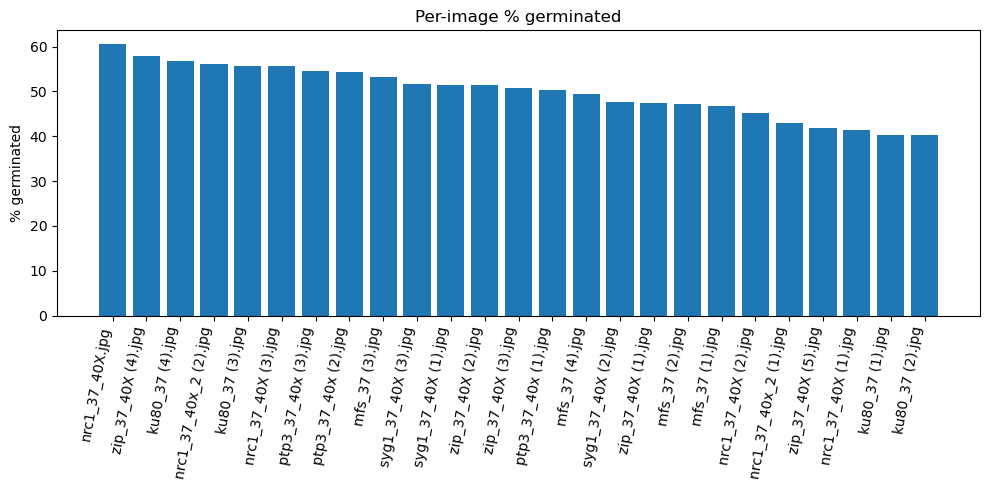

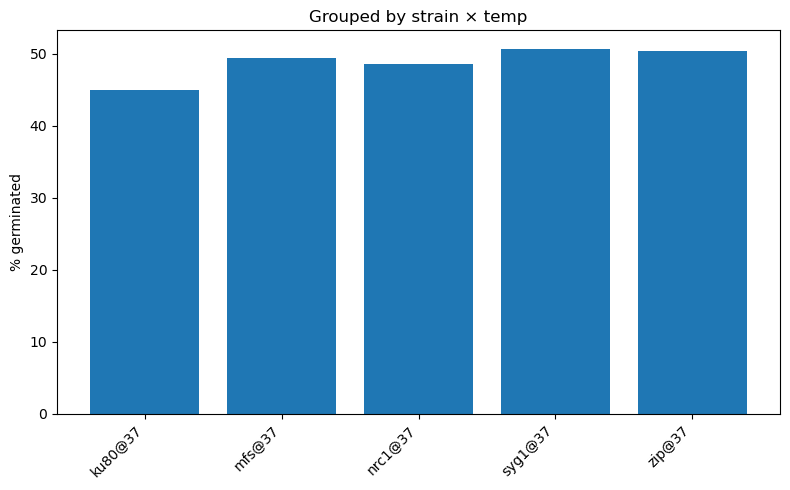

,file,total,germinated,percent_germinated
0,ku80_37 (1).jpg,233,94,40.343348
1,ku80_37 (2).jpg,229,92,40.174672
2,ku80_37 (3).jpg,104,58,55.769231
3,ku80_37 (4).jpg,88,50,56.818182
4,mfs_37 (1).jpg,141,66,46.808511
5,mfs_37 (2).jpg,163,77,47.239264
6,mfs_37 (3).jpg,184,98,53.260870
7,mfs_37 (4).jpg,75,37,49.333333
8,nrc1_37_40X (1).jpg,140,58,41.428571
9,nrc1_37_40X (2).jpg,84,38,45.238095


In [5]:
# === Batch Fungal Germination Counter (Jupyter version) ======================
# 1) Set your folder path below.
# 2) (Optional) Set a regex with (?P<strain>...) and/or (?P<temp>...) to parse metadata from filenames.
# 3) Run this cell.

import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/37C"            # <-- change this
input_glob = os.path.join(image_folder, "*.jpg") # since your files are .jpg
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ppp3)_(?P<temp>\d+)"  
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# Segmentation & classification thresholds (tune if needed)
MIN_AREA = 25
MAX_AREA = 10000
ASPECT_THRESHOLD = 1.8           # major/minor axis ratio (raise to be stricter)
SKELETON_DIAM_RATIO = 1.6        # skeleton length vs equivalent diameter (raise to be stricter)
SAUVOLA_WINDOW = 61
SAUVOLA_K = 0.2
GAUSSIAN_SIGMA = 1.0
OPENING_RADIUS = 1
HOLE_AREA = 64
WATERSHED_SPLIT = True
PEAK_FOOTPRINT = 15
# -----------------------------------------------------------------------------

# ----------------------- CORE FUNCTIONS --------------------------------------
def parse_meta(filename, meta_regex=None):
    """Parse 'strain' and 'temp' from a filename using a regex with named groups."""
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"] = m.groupdict().get("temp")
            return info
    # Fallback heuristics
    s = base.lower()
    for key in ["ku80", "mfs", "zip", "wt", "syg1"]:
        if key in s:
            info["strain"] = key
            break
    mt = re.search(r"(?:^|_|-)(\d{2})(?:c|deg|$|_|-)", s)
    if mt:
        info["temp"] = mt.group(1)
    return info

def analyze_image(path):
    """Return (DataFrame, overlay_array) for a single image."""
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)

    # Enhance & invert (helps for phase-contrast)
    g = exposure.equalize_adapthist(gray, clip_limit=0.01)
    inv = 1.0 - g
    blur = filters.gaussian(inv, sigma=GAUSSIAN_SIGMA)

    # Adaptive threshold + cleanup
    th = filters.threshold_sauvola(blur, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bw = blur > th
    bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
    bw = morphology.remove_small_objects(bw, MIN_AREA)
    bw = morphology.binary_opening(bw, morphology.disk(OPENING_RADIUS))

    # Optional: split touching objects
    if WATERSHED_SPLIT:
        dist = ndi.distance_transform_edt(bw)
        coords = feature.peak_local_max(
            dist, footprint=np.ones((PEAK_FOOTPRINT, PEAK_FOOTPRINT)), labels=bw, exclude_border=False
        )
        seeds = np.zeros_like(dist, dtype=bool)
        if coords.size:
            seeds[tuple(coords.T)] = True
        markers = measure.label(seeds)
        labels = segmentation.watershed(-dist, markers, mask=bw)
    else:
        labels = measure.label(bw)

    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        maj = max(p.major_axis_length, 1.0)
        minr = max(p.minor_axis_length, 1.0)
        aspect = maj / minr
        equiv = p.equivalent_diameter

        skel = morphology.skeletonize(labels == p.label)
        sklen = int(np.count_nonzero(skel))

        # Classification rule
        is_germ = (aspect >= ASPECT_THRESHOLD) or (sklen >= SKELETON_DIAM_RATIO * equiv)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "major_axis_px": float(maj),
            "minor_axis_px": float(minr),
            "aspect_ratio": float(aspect),
            "equiv_diameter_px": float(equiv),
            "skeleton_len_px": int(sklen),
            "is_germinated": int(is_germ),
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    return pd.DataFrame(rows), overlay
# -----------------------------------------------------------------------------

# ----------------------- RUN BATCH -------------------------------------------
paths = [p for p in glob.glob(input_glob)
         if os.path.splitext(p)[1].lower() in {".png", ".jpg", ".jpeg", ".tif", ".tiff"}]
assert len(paths) > 0, f"No images found at: {input_glob}"

all_rows = []
for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if meta["strain"] is not None: df["strain"] = meta["strain"]
    if meta["temp"]   is not None: df["temp"]   = meta["temp"]
    all_rows.append(df)

    if save_overlays_next_to_images:
        out_png = os.path.splitext(p)[0] + "_overlay.png"
    else:
        out_png = os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)
    print(f"{os.path.basename(p)} -> N={len(df)}  germinated={int(df.is_germinated.sum())}  overlay={os.path.basename(out_png)}")

# Per-object table
big = pd.concat(all_rows, ignore_index=True)
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Per-image summary
per_file = big.groupby("file").agg(
    total=("is_germinated","count"),
    germinated=("is_germinated","sum")
).reset_index()
per_file["percent_germinated"] = 100 * per_file["germinated"] / per_file["total"].clip(lower=1)
per_file.to_csv(f"{output_prefix}_perfile.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perfile.csv")

# Optional grouped summary if metadata was parsed
if {"strain","temp"}.issubset(big.columns):
    grouped = big.groupby(["strain","temp"]).agg(
        total=("is_germinated","count"),
        germinated=("is_germinated","sum")
    ).reset_index()
    grouped["percent_germinated"] = 100 * grouped["germinated"] / grouped["total"].clip(lower=1)
    grouped = grouped.sort_values(["strain","temp"])
    grouped.to_csv(f"{output_prefix}_by_strain_temp.csv", index=False)
    print("Saved grouped summary:", f"{output_prefix}_by_strain_temp.csv")
else:
    grouped = None

# ----------------------- PLOTS (Matplotlib; single-plot each) ----------------
# Per-image bar chart
plt.figure(figsize=(10, 5))
order = per_file.sort_values("percent_germinated", ascending=False)
plt.bar(order["file"], order["percent_germinated"])
plt.xticks(rotation=80, ha="right")
plt.ylabel("% germinated")
plt.title("Per-image % germinated")
plt.tight_layout()
plt.show()

# Grouped bar chart (if metadata present)
if grouped is not None and len(grouped):
    plt.figure(figsize=(8, 5))
    xt = [f"{r.strain}@{r.temp}" for r in grouped.itertuples()]
    plt.bar(xt, grouped["percent_germinated"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("% germinated")
    plt.title("Grouped by strain × temp")
    plt.tight_layout()
    plt.show()

# Peek at the top rows in-notebook
per_file.head(10)


ku80_37 (1).jpg -> N=233  germinated=71  overlay=ku80_37 (1)_overlay.png
ku80_37 (2).jpg -> N=229  germinated=65  overlay=ku80_37 (2)_overlay.png
ku80_37 (3).jpg -> N=104  germinated=47  overlay=ku80_37 (3)_overlay.png
ku80_37 (4).jpg -> N=88  germinated=39  overlay=ku80_37 (4)_overlay.png
mfs_37 (1).jpg -> N=141  germinated=43  overlay=mfs_37 (1)_overlay.png
mfs_37 (2).jpg -> N=163  germinated=54  overlay=mfs_37 (2)_overlay.png
mfs_37 (3).jpg -> N=184  germinated=59  overlay=mfs_37 (3)_overlay.png
mfs_37 (4).jpg -> N=75  germinated=29  overlay=mfs_37 (4)_overlay.png
nrc1_37_40X (1).jpg -> N=140  germinated=40  overlay=nrc1_37_40X (1)_overlay.png
nrc1_37_40X (2).jpg -> N=84  germinated=30  overlay=nrc1_37_40X (2)_overlay.png
nrc1_37_40X (3).jpg -> N=79  germinated=37  overlay=nrc1_37_40X (3)_overlay.png
nrc1_37_40X.jpg -> N=66  germinated=31  overlay=nrc1_37_40X_overlay.png
nrc1_37_40x_2 (1).jpg -> N=128  germinated=42  overlay=nrc1_37_40x_2 (1)_overlay.png
nrc1_37_40x_2 (2).jpg -> N=8

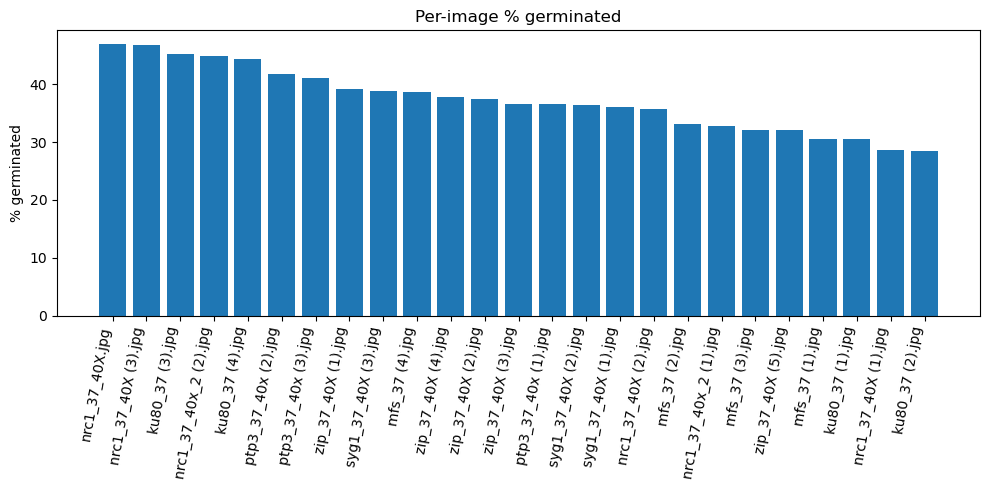

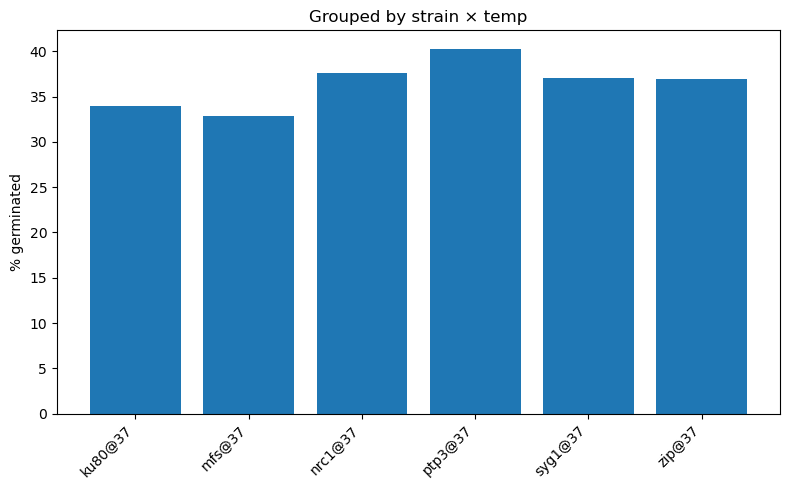

,file,total,germinated,percent_germinated
0,ku80_37 (1).jpg,233,71,30.472103
1,ku80_37 (2).jpg,229,65,28.384279
2,ku80_37 (3).jpg,104,47,45.192308
3,ku80_37 (4).jpg,88,39,44.318182
4,mfs_37 (1).jpg,141,43,30.496454
5,mfs_37 (2).jpg,163,54,33.128834
6,mfs_37 (3).jpg,184,59,32.065217
7,mfs_37 (4).jpg,75,29,38.666667
8,nrc1_37_40X (1).jpg,140,40,28.571429
9,nrc1_37_40X (2).jpg,84,30,35.714286


In [6]:
# === Batch Fungal Germination Counter (Jupyter version) ======================
# 1) Set your folder path below.
# 2) (Optional) Set a regex with (?P<strain>...) and/or (?P<temp>...) to parse metadata from filenames.
# 3) Run this cell.

import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/37C"            # <-- change this
input_glob = os.path.join(image_folder, "*.jpg") # since your files are .jpg
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"  
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# Segmentation & classification thresholds (tune if needed)
MIN_AREA = 25
MAX_AREA = 10000
ASPECT_THRESHOLD = 2.0           # major/minor axis ratio (raise to be stricter)
SKELETON_DIAM_RATIO = 1.8        # skeleton length vs equivalent diameter (raise to be stricter)
SAUVOLA_WINDOW = 61
SAUVOLA_K = 0.2
GAUSSIAN_SIGMA = 1.0
OPENING_RADIUS = 1
HOLE_AREA = 64
WATERSHED_SPLIT = True
PEAK_FOOTPRINT = 15
# -----------------------------------------------------------------------------

# ----------------------- CORE FUNCTIONS --------------------------------------
def parse_meta(filename, meta_regex=None):
    """Parse 'strain' and 'temp' from a filename using a regex with named groups."""
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"] = m.groupdict().get("temp")
            return info
    # Fallback heuristics
    s = base.lower()
    for key in ["ku80", "mfs", "zip", "wt", "ptp", "syg1"]:
        if key in s:
            info["strain"] = key
            break
    mt = re.search(r"(?:^|_|-)(\d{2})(?:c|deg|$|_|-)", s)
    if mt:
        info["temp"] = mt.group(1)
    return info

def analyze_image(path):
    """Return (DataFrame, overlay_array) for a single image."""
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)

    # Enhance & invert (helps for phase-contrast)
    g = exposure.equalize_adapthist(gray, clip_limit=0.01)
    inv = 1.0 - g
    blur = filters.gaussian(inv, sigma=GAUSSIAN_SIGMA)

    # Adaptive threshold + cleanup
    th = filters.threshold_sauvola(blur, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bw = blur > th
    bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
    bw = morphology.remove_small_objects(bw, MIN_AREA)
    bw = morphology.binary_opening(bw, morphology.disk(OPENING_RADIUS))

    # Optional: split touching objects
    if WATERSHED_SPLIT:
        dist = ndi.distance_transform_edt(bw)
        coords = feature.peak_local_max(
            dist, footprint=np.ones((PEAK_FOOTPRINT, PEAK_FOOTPRINT)), labels=bw, exclude_border=False
        )
        seeds = np.zeros_like(dist, dtype=bool)
        if coords.size:
            seeds[tuple(coords.T)] = True
        markers = measure.label(seeds)
        labels = segmentation.watershed(-dist, markers, mask=bw)
    else:
        labels = measure.label(bw)

    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        maj = max(p.major_axis_length, 1.0)
        minr = max(p.minor_axis_length, 1.0)
        aspect = maj / minr
        equiv = p.equivalent_diameter

        skel = morphology.skeletonize(labels == p.label)
        sklen = int(np.count_nonzero(skel))

        # Classification rule
        is_germ = (aspect >= ASPECT_THRESHOLD) or (sklen >= SKELETON_DIAM_RATIO * equiv)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "major_axis_px": float(maj),
            "minor_axis_px": float(minr),
            "aspect_ratio": float(aspect),
            "equiv_diameter_px": float(equiv),
            "skeleton_len_px": int(sklen),
            "is_germinated": int(is_germ),
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    return pd.DataFrame(rows), overlay
# -----------------------------------------------------------------------------

# ----------------------- RUN BATCH -------------------------------------------
paths = [p for p in glob.glob(input_glob)
         if os.path.splitext(p)[1].lower() in {".png", ".jpg", ".jpeg", ".tif", ".tiff"}]
assert len(paths) > 0, f"No images found at: {input_glob}"

all_rows = []
for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if meta["strain"] is not None: df["strain"] = meta["strain"]
    if meta["temp"]   is not None: df["temp"]   = meta["temp"]
    all_rows.append(df)

    if save_overlays_next_to_images:
        out_png = os.path.splitext(p)[0] + "_overlay.png"
    else:
        out_png = os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)
    print(f"{os.path.basename(p)} -> N={len(df)}  germinated={int(df.is_germinated.sum())}  overlay={os.path.basename(out_png)}")

# Per-object table
big = pd.concat(all_rows, ignore_index=True)
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Per-image summary
per_file = big.groupby("file").agg(
    total=("is_germinated","count"),
    germinated=("is_germinated","sum")
).reset_index()
per_file["percent_germinated"] = 100 * per_file["germinated"] / per_file["total"].clip(lower=1)
per_file.to_csv(f"{output_prefix}_perfile.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perfile.csv")

# Optional grouped summary if metadata was parsed
if {"strain","temp"}.issubset(big.columns):
    grouped = big.groupby(["strain","temp"]).agg(
        total=("is_germinated","count"),
        germinated=("is_germinated","sum")
    ).reset_index()
    grouped["percent_germinated"] = 100 * grouped["germinated"] / grouped["total"].clip(lower=1)
    grouped = grouped.sort_values(["strain","temp"])
    grouped.to_csv(f"{output_prefix}_by_strain_temp.csv", index=False)
    print("Saved grouped summary:", f"{output_prefix}_by_strain_temp.csv")
else:
    grouped = None

# ----------------------- PLOTS (Matplotlib; single-plot each) ----------------
# Per-image bar chart
plt.figure(figsize=(10, 5))
order = per_file.sort_values("percent_germinated", ascending=False)
plt.bar(order["file"], order["percent_germinated"])
plt.xticks(rotation=80, ha="right")
plt.ylabel("% germinated")
plt.title("Per-image % germinated")
plt.tight_layout()
plt.show()

# Grouped bar chart (if metadata present)
if grouped is not None and len(grouped):
    plt.figure(figsize=(8, 5))
    xt = [f"{r.strain}@{r.temp}" for r in grouped.itertuples()]
    plt.bar(xt, grouped["percent_germinated"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("% germinated")
    plt.title("Grouped by strain × temp")
    plt.tight_layout()
    plt.show()

# Peek at the top rows in-notebook
per_file.head(10)


ku80_37 (1).jpg -> N=233  germinated=53  overlay=ku80_37 (1)_overlay.png
ku80_37 (2).jpg -> N=229  germinated=48  overlay=ku80_37 (2)_overlay.png
ku80_37 (3).jpg -> N=104  germinated=40  overlay=ku80_37 (3)_overlay.png
ku80_37 (4).jpg -> N=88  germinated=31  overlay=ku80_37 (4)_overlay.png
mfs_37 (1).jpg -> N=141  germinated=34  overlay=mfs_37 (1)_overlay.png
mfs_37 (2).jpg -> N=163  germinated=43  overlay=mfs_37 (2)_overlay.png
mfs_37 (3).jpg -> N=184  germinated=44  overlay=mfs_37 (3)_overlay.png
mfs_37 (4).jpg -> N=75  germinated=22  overlay=mfs_37 (4)_overlay.png
nrc1_37_40X (1).jpg -> N=140  germinated=27  overlay=nrc1_37_40X (1)_overlay.png
nrc1_37_40X (2).jpg -> N=84  germinated=21  overlay=nrc1_37_40X (2)_overlay.png
nrc1_37_40X (3).jpg -> N=79  germinated=27  overlay=nrc1_37_40X (3)_overlay.png
nrc1_37_40X.jpg -> N=66  germinated=24  overlay=nrc1_37_40X_overlay.png
nrc1_37_40x_2 (1).jpg -> N=128  germinated=36  overlay=nrc1_37_40x_2 (1)_overlay.png
nrc1_37_40x_2 (2).jpg -> N=8

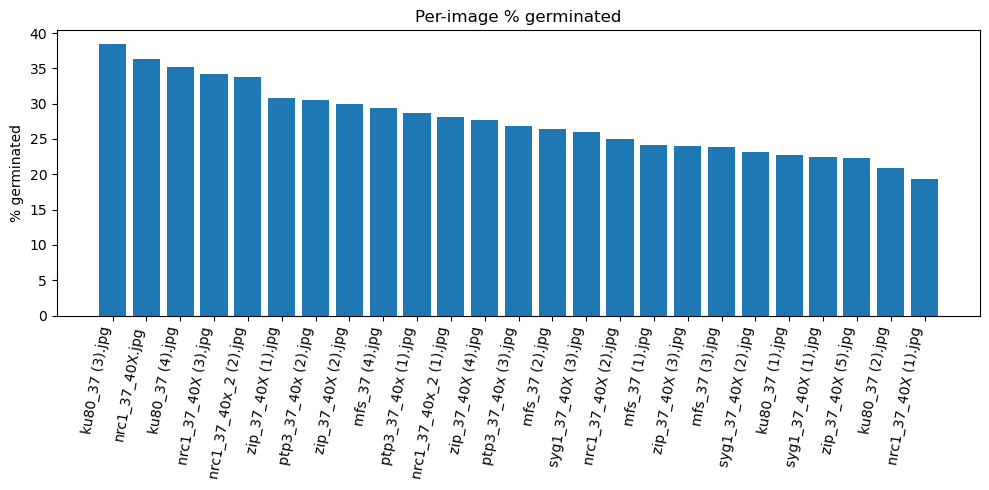

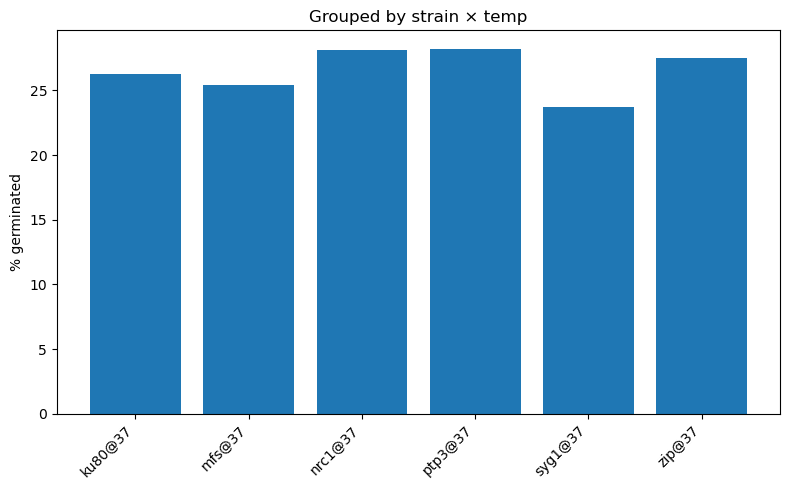

,file,total,germinated,percent_germinated
0,ku80_37 (1).jpg,233,53,22.746781
1,ku80_37 (2).jpg,229,48,20.960699
2,ku80_37 (3).jpg,104,40,38.461538
3,ku80_37 (4).jpg,88,31,35.227273
4,mfs_37 (1).jpg,141,34,24.113475
5,mfs_37 (2).jpg,163,43,26.380368
6,mfs_37 (3).jpg,184,44,23.913043
7,mfs_37 (4).jpg,75,22,29.333333
8,nrc1_37_40X (1).jpg,140,27,19.285714
9,nrc1_37_40X (2).jpg,84,21,25.000000


In [7]:
# === Batch Fungal Germination Counter (Jupyter version) ======================
# 1) Set your folder path below.
# 2) (Optional) Set a regex with (?P<strain>...) and/or (?P<temp>...) to parse metadata from filenames.
# 3) Run this cell.

import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/37C"            # <-- change this
input_glob = os.path.join(image_folder, "*.jpg") # since your files are .jpg
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"  
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# Segmentation & classification thresholds (tune if needed)
MIN_AREA = 25
MAX_AREA = 10000
ASPECT_THRESHOLD = 2.2           # major/minor axis ratio (raise to be stricter)
SKELETON_DIAM_RATIO = 2.0        # skeleton length vs equivalent diameter (raise to be stricter)
SAUVOLA_WINDOW = 61
SAUVOLA_K = 0.2
GAUSSIAN_SIGMA = 1.0
OPENING_RADIUS = 1
HOLE_AREA = 64
WATERSHED_SPLIT = True
PEAK_FOOTPRINT = 15
# -----------------------------------------------------------------------------

# ----------------------- CORE FUNCTIONS --------------------------------------
def parse_meta(filename, meta_regex=None):
    """Parse 'strain' and 'temp' from a filename using a regex with named groups."""
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"] = m.groupdict().get("temp")
            return info
    # Fallback heuristics
    s = base.lower()
    for key in ["ku80", "mfs", "zip", "wt", "ptp", "syg1"]:
        if key in s:
            info["strain"] = key
            break
    mt = re.search(r"(?:^|_|-)(\d{2})(?:c|deg|$|_|-)", s)
    if mt:
        info["temp"] = mt.group(1)
    return info

def analyze_image(path):
    """Return (DataFrame, overlay_array) for a single image."""
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)

    # Enhance & invert (helps for phase-contrast)
    g = exposure.equalize_adapthist(gray, clip_limit=0.01)
    inv = 1.0 - g
    blur = filters.gaussian(inv, sigma=GAUSSIAN_SIGMA)

    # Adaptive threshold + cleanup
    th = filters.threshold_sauvola(blur, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bw = blur > th
    bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
    bw = morphology.remove_small_objects(bw, MIN_AREA)
    bw = morphology.binary_opening(bw, morphology.disk(OPENING_RADIUS))

    # Optional: split touching objects
    if WATERSHED_SPLIT:
        dist = ndi.distance_transform_edt(bw)
        coords = feature.peak_local_max(
            dist, footprint=np.ones((PEAK_FOOTPRINT, PEAK_FOOTPRINT)), labels=bw, exclude_border=False
        )
        seeds = np.zeros_like(dist, dtype=bool)
        if coords.size:
            seeds[tuple(coords.T)] = True
        markers = measure.label(seeds)
        labels = segmentation.watershed(-dist, markers, mask=bw)
    else:
        labels = measure.label(bw)

    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        maj = max(p.major_axis_length, 1.0)
        minr = max(p.minor_axis_length, 1.0)
        aspect = maj / minr
        equiv = p.equivalent_diameter

        skel = morphology.skeletonize(labels == p.label)
        sklen = int(np.count_nonzero(skel))

        # Classification rule
        is_germ = (aspect >= ASPECT_THRESHOLD) or (sklen >= SKELETON_DIAM_RATIO * equiv)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "major_axis_px": float(maj),
            "minor_axis_px": float(minr),
            "aspect_ratio": float(aspect),
            "equiv_diameter_px": float(equiv),
            "skeleton_len_px": int(sklen),
            "is_germinated": int(is_germ),
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    return pd.DataFrame(rows), overlay
# -----------------------------------------------------------------------------

# ----------------------- RUN BATCH -------------------------------------------
paths = [p for p in glob.glob(input_glob)
         if os.path.splitext(p)[1].lower() in {".png", ".jpg", ".jpeg", ".tif", ".tiff"}]
assert len(paths) > 0, f"No images found at: {input_glob}"

all_rows = []
for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if meta["strain"] is not None: df["strain"] = meta["strain"]
    if meta["temp"]   is not None: df["temp"]   = meta["temp"]
    all_rows.append(df)

    if save_overlays_next_to_images:
        out_png = os.path.splitext(p)[0] + "_overlay.png"
    else:
        out_png = os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)
    print(f"{os.path.basename(p)} -> N={len(df)}  germinated={int(df.is_germinated.sum())}  overlay={os.path.basename(out_png)}")

# Per-object table
big = pd.concat(all_rows, ignore_index=True)
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Per-image summary
per_file = big.groupby("file").agg(
    total=("is_germinated","count"),
    germinated=("is_germinated","sum")
).reset_index()
per_file["percent_germinated"] = 100 * per_file["germinated"] / per_file["total"].clip(lower=1)
per_file.to_csv(f"{output_prefix}_perfile.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perfile.csv")

# Optional grouped summary if metadata was parsed
if {"strain","temp"}.issubset(big.columns):
    grouped = big.groupby(["strain","temp"]).agg(
        total=("is_germinated","count"),
        germinated=("is_germinated","sum")
    ).reset_index()
    grouped["percent_germinated"] = 100 * grouped["germinated"] / grouped["total"].clip(lower=1)
    grouped = grouped.sort_values(["strain","temp"])
    grouped.to_csv(f"{output_prefix}_by_strain_temp.csv", index=False)
    print("Saved grouped summary:", f"{output_prefix}_by_strain_temp.csv")
else:
    grouped = None

# ----------------------- PLOTS (Matplotlib; single-plot each) ----------------
# Per-image bar chart
plt.figure(figsize=(10, 5))
order = per_file.sort_values("percent_germinated", ascending=False)
plt.bar(order["file"], order["percent_germinated"])
plt.xticks(rotation=80, ha="right")
plt.ylabel("% germinated")
plt.title("Per-image % germinated")
plt.tight_layout()
plt.show()

# Grouped bar chart (if metadata present)
if grouped is not None and len(grouped):
    plt.figure(figsize=(8, 5))
    xt = [f"{r.strain}@{r.temp}" for r in grouped.itertuples()]
    plt.bar(xt, grouped["percent_germinated"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("% germinated")
    plt.title("Grouped by strain × temp")
    plt.tight_layout()
    plt.show()

# Peek at the top rows in-notebook
per_file.head(10)


### for 45C

ku80_45_40x (1).jpg -> N=2036  germinated=730  overlay=ku80_45_40x (1)_overlay.png
ku80_45_40x (2).jpg -> N=1958  germinated=625  overlay=ku80_45_40x (2)_overlay.png
ku80_45_40x (3).jpg -> N=1189  germinated=398  overlay=ku80_45_40x (3)_overlay.png
mfs_45_40x (1).jpg -> N=1050  germinated=401  overlay=mfs_45_40x (1)_overlay.png
mfs_45_40x (2).jpg -> N=869  germinated=299  overlay=mfs_45_40x (2)_overlay.png
mfs_45_40x (3).jpg -> N=50  germinated=18  overlay=mfs_45_40x (3)_overlay.png
nrc1_45_40x (1).jpg -> N=171  germinated=57  overlay=nrc1_45_40x (1)_overlay.png
nrc1_45_40x (2).jpg -> N=312  germinated=92  overlay=nrc1_45_40x (2)_overlay.png
nrc1_45_40x (3).jpg -> N=1837  germinated=657  overlay=nrc1_45_40x (3)_overlay.png
ptp3_45_40x (1).jpg -> N=1590  germinated=574  overlay=ptp3_45_40x (1)_overlay.png
ptp3_45_40x (2).jpg -> N=69  germinated=27  overlay=ptp3_45_40x (2)_overlay.png
ptp3_45_40x (3).jpg -> N=44  germinated=20  overlay=ptp3_45_40x (3)_overlay.png
syg1_45_40x (1).jpg -> N

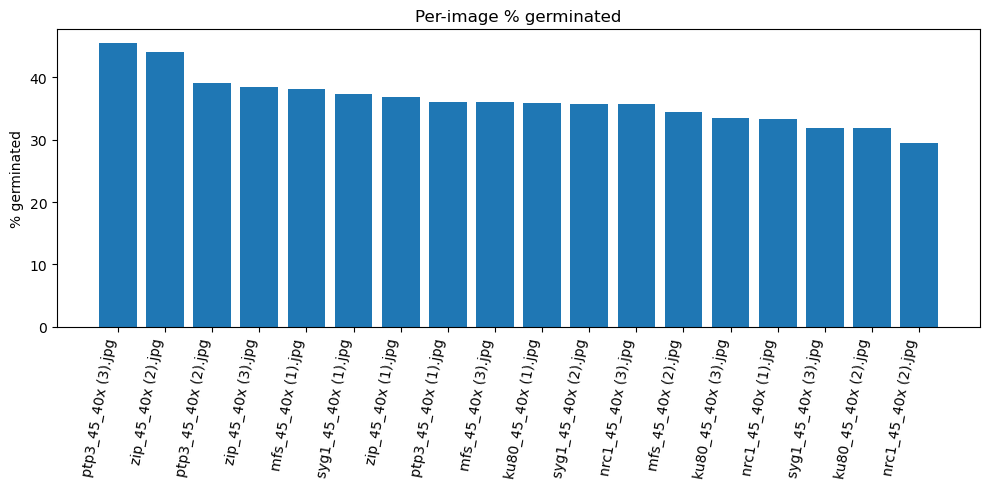

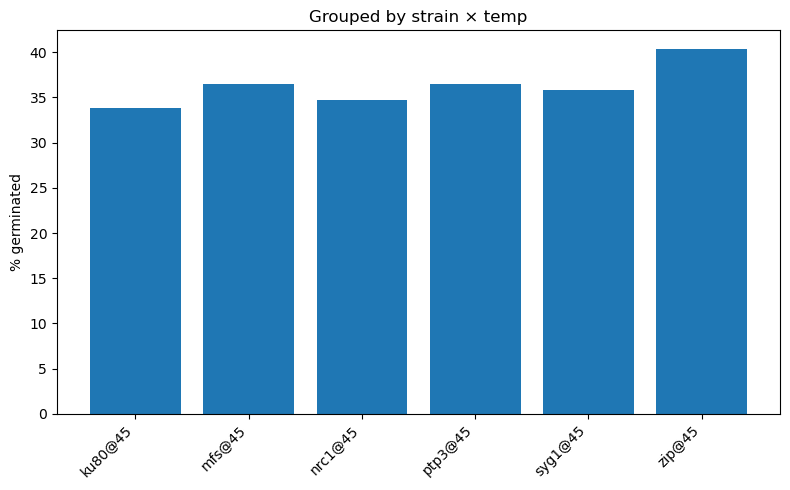

,file,total,germinated,percent_germinated
0,ku80_45_40x (1).jpg,2036,730,35.854617
1,ku80_45_40x (2).jpg,1958,625,31.920327
2,ku80_45_40x (3).jpg,1189,398,33.473507
3,mfs_45_40x (1).jpg,1050,401,38.190476
4,mfs_45_40x (2).jpg,869,299,34.407365
5,mfs_45_40x (3).jpg,50,18,36.000000
6,nrc1_45_40x (1).jpg,171,57,33.333333
7,nrc1_45_40x (2).jpg,312,92,29.487179
8,nrc1_45_40x (3).jpg,1837,657,35.764834
9,ptp3_45_40x (1).jpg,1590,574,36.100629


In [1]:
# === Batch Fungal Germination Counter (Jupyter version) ======================
# 1) Set your folder path below.
# 2) (Optional) Set a regex with (?P<strain>...) and/or (?P<temp>...) to parse metadata from filenames.
# 3) Run this cell.

import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/45C"            # <-- change this
input_glob = os.path.join(image_folder, "*.jpg") # since your files are .jpg
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"  
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# Segmentation & classification thresholds (tune if needed)
MIN_AREA = 25
MAX_AREA = 10000
ASPECT_THRESHOLD = 2.0           # major/minor axis ratio (raise to be stricter)
SKELETON_DIAM_RATIO = 1.8        # skeleton length vs equivalent diameter (raise to be stricter)
SAUVOLA_WINDOW = 61
SAUVOLA_K = 0.2
GAUSSIAN_SIGMA = 1.0
OPENING_RADIUS = 1
HOLE_AREA = 64
WATERSHED_SPLIT = True
PEAK_FOOTPRINT = 15
# -----------------------------------------------------------------------------

# ----------------------- CORE FUNCTIONS --------------------------------------
def parse_meta(filename, meta_regex=None):
    """Parse 'strain' and 'temp' from a filename using a regex with named groups."""
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"] = m.groupdict().get("temp")
            return info
    # Fallback heuristics
    s = base.lower()
    for key in ["ku80", "mfs", "zip", "wt", "ptp", "syg1"]:
        if key in s:
            info["strain"] = key
            break
    mt = re.search(r"(?:^|_|-)(\d{2})(?:c|deg|$|_|-)", s)
    if mt:
        info["temp"] = mt.group(1)
    return info

def analyze_image(path):
    """Return (DataFrame, overlay_array) for a single image."""
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)

    # Enhance & invert (helps for phase-contrast)
    g = exposure.equalize_adapthist(gray, clip_limit=0.01)
    inv = 1.0 - g
    blur = filters.gaussian(inv, sigma=GAUSSIAN_SIGMA)

    # Adaptive threshold + cleanup
    th = filters.threshold_sauvola(blur, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bw = blur > th
    bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
    bw = morphology.remove_small_objects(bw, MIN_AREA)
    bw = morphology.binary_opening(bw, morphology.disk(OPENING_RADIUS))

    # Optional: split touching objects
    if WATERSHED_SPLIT:
        dist = ndi.distance_transform_edt(bw)
        coords = feature.peak_local_max(
            dist, footprint=np.ones((PEAK_FOOTPRINT, PEAK_FOOTPRINT)), labels=bw, exclude_border=False
        )
        seeds = np.zeros_like(dist, dtype=bool)
        if coords.size:
            seeds[tuple(coords.T)] = True
        markers = measure.label(seeds)
        labels = segmentation.watershed(-dist, markers, mask=bw)
    else:
        labels = measure.label(bw)

    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        maj = max(p.major_axis_length, 1.0)
        minr = max(p.minor_axis_length, 1.0)
        aspect = maj / minr
        equiv = p.equivalent_diameter

        skel = morphology.skeletonize(labels == p.label)
        sklen = int(np.count_nonzero(skel))

        # Classification rule
        is_germ = (aspect >= ASPECT_THRESHOLD) or (sklen >= SKELETON_DIAM_RATIO * equiv)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "major_axis_px": float(maj),
            "minor_axis_px": float(minr),
            "aspect_ratio": float(aspect),
            "equiv_diameter_px": float(equiv),
            "skeleton_len_px": int(sklen),
            "is_germinated": int(is_germ),
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    return pd.DataFrame(rows), overlay
# -----------------------------------------------------------------------------

# ----------------------- RUN BATCH -------------------------------------------
paths = [p for p in glob.glob(input_glob)
         if os.path.splitext(p)[1].lower() in {".png", ".jpg", ".jpeg", ".tif", ".tiff"}]
assert len(paths) > 0, f"No images found at: {input_glob}"

all_rows = []
for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if meta["strain"] is not None: df["strain"] = meta["strain"]
    if meta["temp"]   is not None: df["temp"]   = meta["temp"]
    all_rows.append(df)

    if save_overlays_next_to_images:
        out_png = os.path.splitext(p)[0] + "_overlay.png"
    else:
        out_png = os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)
    print(f"{os.path.basename(p)} -> N={len(df)}  germinated={int(df.is_germinated.sum())}  overlay={os.path.basename(out_png)}")

# Per-object table
big = pd.concat(all_rows, ignore_index=True)
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Per-image summary
per_file = big.groupby("file").agg(
    total=("is_germinated","count"),
    germinated=("is_germinated","sum")
).reset_index()
per_file["percent_germinated"] = 100 * per_file["germinated"] / per_file["total"].clip(lower=1)
per_file.to_csv(f"{output_prefix}_perfile.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perfile.csv")

# Optional grouped summary if metadata was parsed
if {"strain","temp"}.issubset(big.columns):
    grouped = big.groupby(["strain","temp"]).agg(
        total=("is_germinated","count"),
        germinated=("is_germinated","sum")
    ).reset_index()
    grouped["percent_germinated"] = 100 * grouped["germinated"] / grouped["total"].clip(lower=1)
    grouped = grouped.sort_values(["strain","temp"])
    grouped.to_csv(f"{output_prefix}_by_strain_temp.csv", index=False)
    print("Saved grouped summary:", f"{output_prefix}_by_strain_temp.csv")
else:
    grouped = None

# ----------------------- PLOTS (Matplotlib; single-plot each) ----------------
# Per-image bar chart
plt.figure(figsize=(10, 5))
order = per_file.sort_values("percent_germinated", ascending=False)
plt.bar(order["file"], order["percent_germinated"])
plt.xticks(rotation=80, ha="right")
plt.ylabel("% germinated")
plt.title("Per-image % germinated")
plt.tight_layout()
plt.show()

# Grouped bar chart (if metadata present)
if grouped is not None and len(grouped):
    plt.figure(figsize=(8, 5))
    xt = [f"{r.strain}@{r.temp}" for r in grouped.itertuples()]
    plt.bar(xt, grouped["percent_germinated"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("% germinated")
    plt.title("Grouped by strain × temp")
    plt.tight_layout()
    plt.show()

# Peek at the top rows in-notebook
per_file.head(10)


### for 50C

ku80_37 (1).jpg -> N=233  germinated=71  overlay=ku80_37 (1)_overlay.png
ku80_37 (2).jpg -> N=229  germinated=65  overlay=ku80_37 (2)_overlay.png
ku80_37 (3).jpg -> N=104  germinated=47  overlay=ku80_37 (3)_overlay.png
ku80_37 (4).jpg -> N=88  germinated=39  overlay=ku80_37 (4)_overlay.png
mfs_37 (1).jpg -> N=141  germinated=43  overlay=mfs_37 (1)_overlay.png
mfs_37 (2).jpg -> N=163  germinated=54  overlay=mfs_37 (2)_overlay.png
mfs_37 (3).jpg -> N=184  germinated=59  overlay=mfs_37 (3)_overlay.png
mfs_37 (4).jpg -> N=75  germinated=29  overlay=mfs_37 (4)_overlay.png
nrc1_37_40X (1).jpg -> N=140  germinated=40  overlay=nrc1_37_40X (1)_overlay.png
nrc1_37_40X (2).jpg -> N=84  germinated=30  overlay=nrc1_37_40X (2)_overlay.png
nrc1_37_40X (3).jpg -> N=79  germinated=37  overlay=nrc1_37_40X (3)_overlay.png
nrc1_37_40X.jpg -> N=66  germinated=31  overlay=nrc1_37_40X_overlay.png
nrc1_37_40x_2 (1).jpg -> N=128  germinated=42  overlay=nrc1_37_40x_2 (1)_overlay.png
nrc1_37_40x_2 (2).jpg -> N=8

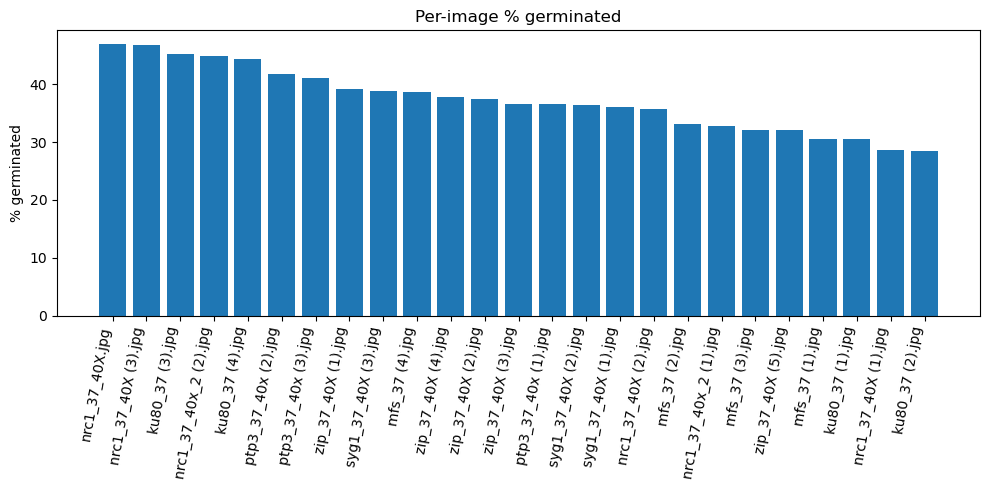

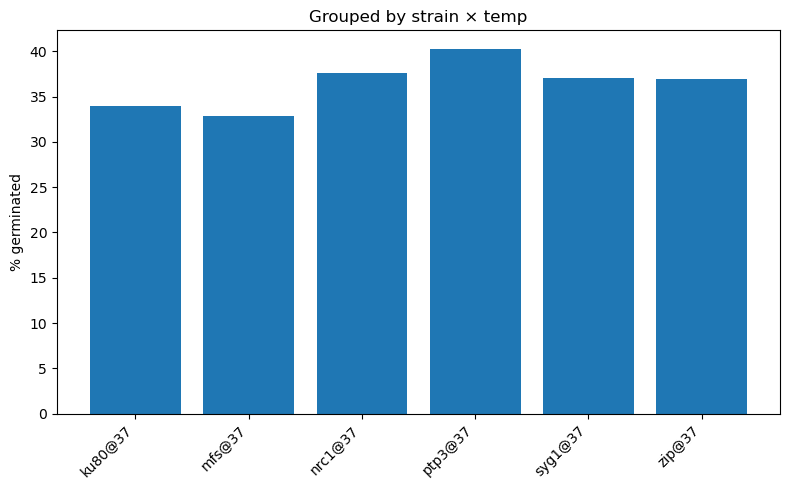

,file,total,germinated,percent_germinated
0,ku80_37 (1).jpg,233,71,30.472103
1,ku80_37 (2).jpg,229,65,28.384279
2,ku80_37 (3).jpg,104,47,45.192308
3,ku80_37 (4).jpg,88,39,44.318182
4,mfs_37 (1).jpg,141,43,30.496454
5,mfs_37 (2).jpg,163,54,33.128834
6,mfs_37 (3).jpg,184,59,32.065217
7,mfs_37 (4).jpg,75,29,38.666667
8,nrc1_37_40X (1).jpg,140,40,28.571429
9,nrc1_37_40X (2).jpg,84,30,35.714286


In [2]:
# === Batch Fungal Germination Counter (Jupyter version) ======================
# 1) Set your folder path below.
# 2) (Optional) Set a regex with (?P<strain>...) and/or (?P<temp>...) to parse metadata from filenames.
# 3) Run this cell.

import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/37C"            # <-- change this
input_glob = os.path.join(image_folder, "*.jpg") # since your files are .jpg
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"  
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# Segmentation & classification thresholds (tune if needed)
MIN_AREA = 25
MAX_AREA = 10000
ASPECT_THRESHOLD = 2.0           # major/minor axis ratio (raise to be stricter)
SKELETON_DIAM_RATIO = 1.8        # skeleton length vs equivalent diameter (raise to be stricter)
SAUVOLA_WINDOW = 61
SAUVOLA_K = 0.2
GAUSSIAN_SIGMA = 1.0
OPENING_RADIUS = 1
HOLE_AREA = 64
WATERSHED_SPLIT = True
PEAK_FOOTPRINT = 15
# -----------------------------------------------------------------------------

# ----------------------- CORE FUNCTIONS --------------------------------------
def parse_meta(filename, meta_regex=None):
    """Parse 'strain' and 'temp' from a filename using a regex with named groups."""
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None}
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"] = m.groupdict().get("temp")
            return info
    # Fallback heuristics
    s = base.lower()
    for key in ["ku80", "mfs", "zip", "wt", "ptp", "syg1"]:
        if key in s:
            info["strain"] = key
            break
    mt = re.search(r"(?:^|_|-)(\d{2})(?:c|deg|$|_|-)", s)
    if mt:
        info["temp"] = mt.group(1)
    return info

def analyze_image(path):
    """Return (DataFrame, overlay_array) for a single image."""
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)

    # Enhance & invert (helps for phase-contrast)
    g = exposure.equalize_adapthist(gray, clip_limit=0.01)
    inv = 1.0 - g
    blur = filters.gaussian(inv, sigma=GAUSSIAN_SIGMA)

    # Adaptive threshold + cleanup
    th = filters.threshold_sauvola(blur, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bw = blur > th
    bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
    bw = morphology.remove_small_objects(bw, MIN_AREA)
    bw = morphology.binary_opening(bw, morphology.disk(OPENING_RADIUS))

    # Optional: split touching objects
    if WATERSHED_SPLIT:
        dist = ndi.distance_transform_edt(bw)
        coords = feature.peak_local_max(
            dist, footprint=np.ones((PEAK_FOOTPRINT, PEAK_FOOTPRINT)), labels=bw, exclude_border=False
        )
        seeds = np.zeros_like(dist, dtype=bool)
        if coords.size:
            seeds[tuple(coords.T)] = True
        markers = measure.label(seeds)
        labels = segmentation.watershed(-dist, markers, mask=bw)
    else:
        labels = measure.label(bw)

    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        maj = max(p.major_axis_length, 1.0)
        minr = max(p.minor_axis_length, 1.0)
        aspect = maj / minr
        equiv = p.equivalent_diameter

        skel = morphology.skeletonize(labels == p.label)
        sklen = int(np.count_nonzero(skel))

        # Classification rule
        is_germ = (aspect >= ASPECT_THRESHOLD) or (sklen >= SKELETON_DIAM_RATIO * equiv)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "major_axis_px": float(maj),
            "minor_axis_px": float(minr),
            "aspect_ratio": float(aspect),
            "equiv_diameter_px": float(equiv),
            "skeleton_len_px": int(sklen),
            "is_germinated": int(is_germ),
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    return pd.DataFrame(rows), overlay
# -----------------------------------------------------------------------------

# ----------------------- RUN BATCH -------------------------------------------
paths = [p for p in glob.glob(input_glob)
         if os.path.splitext(p)[1].lower() in {".png", ".jpg", ".jpeg", ".tif", ".tiff"}]
assert len(paths) > 0, f"No images found at: {input_glob}"

all_rows = []
for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)
    if meta["strain"] is not None: df["strain"] = meta["strain"]
    if meta["temp"]   is not None: df["temp"]   = meta["temp"]
    all_rows.append(df)

    if save_overlays_next_to_images:
        out_png = os.path.splitext(p)[0] + "_overlay.png"
    else:
        out_png = os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)
    print(f"{os.path.basename(p)} -> N={len(df)}  germinated={int(df.is_germinated.sum())}  overlay={os.path.basename(out_png)}")

# Per-object table
big = pd.concat(all_rows, ignore_index=True)
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# Per-image summary
per_file = big.groupby("file").agg(
    total=("is_germinated","count"),
    germinated=("is_germinated","sum")
).reset_index()
per_file["percent_germinated"] = 100 * per_file["germinated"] / per_file["total"].clip(lower=1)
per_file.to_csv(f"{output_prefix}_perfile.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perfile.csv")

# Optional grouped summary if metadata was parsed
if {"strain","temp"}.issubset(big.columns):
    grouped = big.groupby(["strain","temp"]).agg(
        total=("is_germinated","count"),
        germinated=("is_germinated","sum")
    ).reset_index()
    grouped["percent_germinated"] = 100 * grouped["germinated"] / grouped["total"].clip(lower=1)
    grouped = grouped.sort_values(["strain","temp"])
    grouped.to_csv(f"{output_prefix}_by_strain_temp.csv", index=False)
    print("Saved grouped summary:", f"{output_prefix}_by_strain_temp.csv")
else:
    grouped = None

# ----------------------- PLOTS (Matplotlib; single-plot each) ----------------
# Per-image bar chart
plt.figure(figsize=(10, 5))
order = per_file.sort_values("percent_germinated", ascending=False)
plt.bar(order["file"], order["percent_germinated"])
plt.xticks(rotation=80, ha="right")
plt.ylabel("% germinated")
plt.title("Per-image % germinated")
plt.tight_layout()
plt.show()

# Grouped bar chart (if metadata present)
if grouped is not None and len(grouped):
    plt.figure(figsize=(8, 5))
    xt = [f"{r.strain}@{r.temp}" for r in grouped.itertuples()]
    plt.bar(xt, grouped["percent_germinated"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("% germinated")
    plt.title("Grouped by strain × temp")
    plt.tight_layout()
    plt.show()

# Peek at the top rows in-notebook
per_file.head(10)


Syg1_50C_40x (1).jpg -> N=835  germinated=351  overlay=Syg1_50C_40x (1)_overlay.png
Syg1_50C_40x (2).jpg -> N=1030  germinated=325  overlay=Syg1_50C_40x (2)_overlay.png
Syg1_50C_40x (3).jpg -> N=579  germinated=245  overlay=Syg1_50C_40x (3)_overlay.png
ku80_50_40x (1).jpg -> N=470  germinated=159  overlay=ku80_50_40x (1)_overlay.png
ku80_50_40x (2).jpg -> N=369  germinated=138  overlay=ku80_50_40x (2)_overlay.png
ku80_50_40x (3).jpg -> N=215  germinated=82  overlay=ku80_50_40x (3)_overlay.png
ku80_50_40x (4).jpg -> N=168  germinated=52  overlay=ku80_50_40x (4)_overlay.png
mfs_50_40x (1).jpg -> N=1133  germinated=402  overlay=mfs_50_40x (1)_overlay.png
mfs_50_40x (2).jpg -> N=465  germinated=166  overlay=mfs_50_40x (2)_overlay.png
mfs_50_40x (3).jpg -> N=346  germinated=147  overlay=mfs_50_40x (3)_overlay.png
nrc1_50C_40x (1).jpg -> N=362  germinated=120  overlay=nrc1_50C_40x (1)_overlay.png
nrc1_50C_40x (2).jpg -> N=118  germinated=39  overlay=nrc1_50C_40x (2)_overlay.png
nrc1_50C_40x 

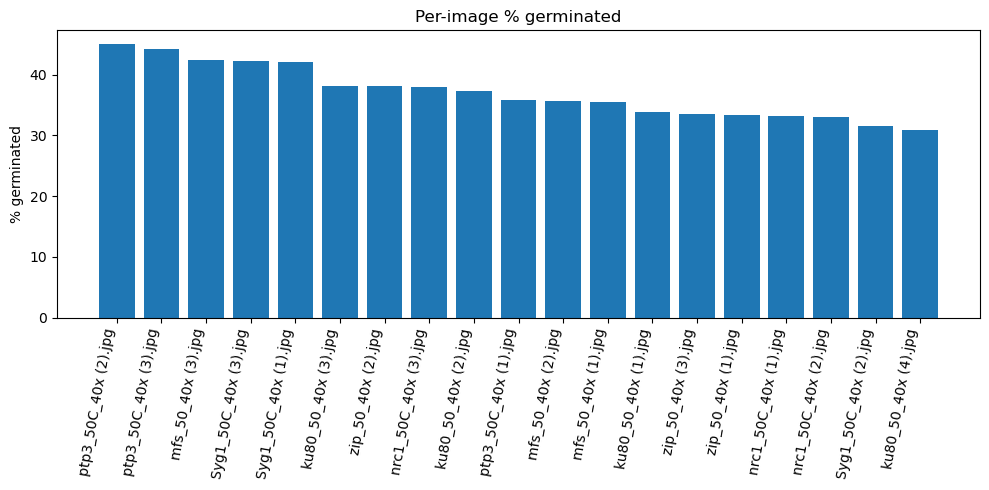

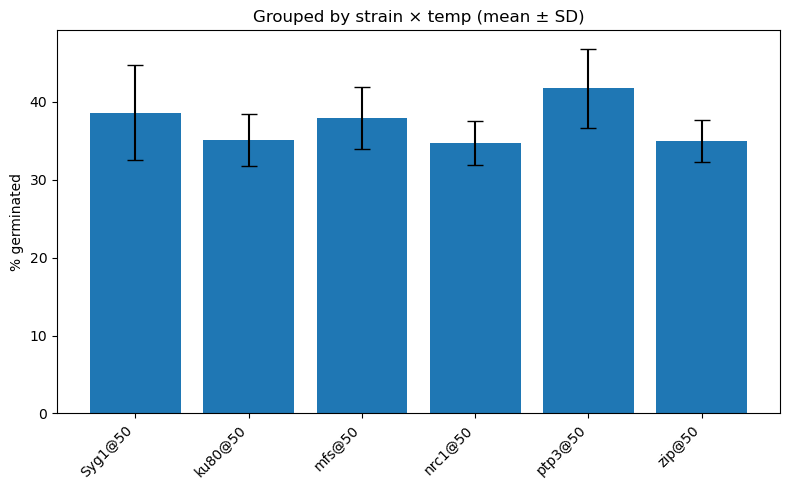

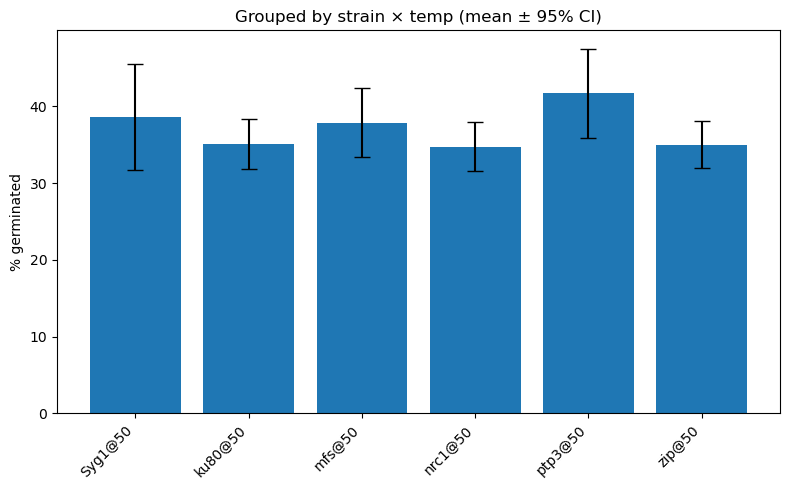

,strain,temp,mean,std,count,sem,ci95
0,Syg1,50,38.634554,6.134040,3,3.541490,6.941320
1,ku80,50,35.080019,3.333461,4,1.666730,3.266792
2,mfs,50,37.888499,3.982653,3,2.299386,4.506796
3,nrc1,50,34.742729,2.845699,3,1.642965,3.220212
4,ptp3,50,41.733868,5.122532,3,2.957495,5.796691
5,zip,50,35.020822,2.698706,3,1.558099,3.053874


In [4]:
# === Batch Fungal Germination Counter (Jupyter version) ======================
# Adds: mean±SD/SEM/95% CI per strain×temp + error-bar plots + replicate parsing

import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/50C"
input_glob = os.path.join(image_folder, "*.jpg")
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"  # include all 6 strains
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# Segmentation & classification thresholds (tune if needed)
MIN_AREA = 25
MAX_AREA = 10000
ASPECT_THRESHOLD = 2.0           # stricter
SKELETON_DIAM_RATIO = 1.8        # stricter
SAUVOLA_WINDOW = 61
SAUVOLA_K = 0.2
GAUSSIAN_SIGMA = 1.0
OPENING_RADIUS = 1
HOLE_AREA = 64
WATERSHED_SPLIT = True
PEAK_FOOTPRINT = 15
# -----------------------------------------------------------------------------

# ----------------------- CORE FUNCTIONS --------------------------------------
def parse_meta(filename, meta_regex=None):
    """Parse strain, temp, and replicate from filename."""
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}

    # Regex with named groups (recommended)
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")

    # Fallback heuristics (if regex not provided or didn’t match)
    s = base.lower()
    if info["strain"] is None:
        for key in ["ku80", "mfs", "zip", "wt", "ptp3", "syg1", "nrc1"]:
            if key in s:
                info["strain"] = key
                break
    if info["temp"] is None:
        mt = re.search(r"(?:^|_|-)(\d{2})(?:c|deg|$|_|-)", s)
        if mt:
            info["temp"] = mt.group(1)

    # Replicate like " (3).jpg"
    mr = re.search(r"\((\d+)\)", base)
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    """Return (DataFrame, overlay_array) for a single image."""
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)

    # Enhance & invert (helps for phase-contrast)
    g = exposure.equalize_adapthist(gray, clip_limit=0.01)
    inv = 1.0 - g
    blur = filters.gaussian(inv, sigma=GAUSSIAN_SIGMA)

    # Adaptive threshold + cleanup
    th = filters.threshold_sauvola(blur, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bw = blur > th
    bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
    bw = morphology.remove_small_objects(bw, MIN_AREA)
    bw = morphology.binary_opening(bw, morphology.disk(OPENING_RADIUS))

    # Optional: split touching objects
    if WATERSHED_SPLIT:
        dist = ndi.distance_transform_edt(bw)
        coords = feature.peak_local_max(
            dist, footprint=np.ones((PEAK_FOOTPRINT, PEAK_FOOTPRINT)), labels=bw, exclude_border=False
        )
        seeds = np.zeros_like(dist, dtype=bool)
        if coords.size:
            seeds[tuple(coords.T)] = True
        markers = measure.label(seeds)
        labels = segmentation.watershed(-dist, markers, mask=bw)
    else:
        labels = measure.label(bw)

    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        maj = max(p.major_axis_length, 1.0)
        minr = max(p.minor_axis_length, 1.0)
        aspect = maj / minr
        equiv  = p.equivalent_diameter

        skel = morphology.skeletonize(labels == p.label)
        sklen = int(np.count_nonzero(skel))

        # Classification rule (OR)
        is_germ = (aspect >= ASPECT_THRESHOLD) or (sklen >= SKELETON_DIAM_RATIO * equiv)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "major_axis_px": float(maj),
            "minor_axis_px": float(minr),
            "aspect_ratio": float(aspect),
            "equiv_diameter_px": float(equiv),
            "skeleton_len_px": int(sklen),
            "is_germinated": int(is_germ),
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    return pd.DataFrame(rows), overlay
# -----------------------------------------------------------------------------

# ----------------------- RUN BATCH -------------------------------------------
paths = [p for p in glob.glob(input_glob)
         if os.path.splitext(p)[1].lower() in {".png", ".jpg", ".jpeg", ".tif", ".tiff"}]
assert len(paths) > 0, f"No images found at: {input_glob}"

all_rows = []
meta_rows = []
for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)

    if meta["strain"] is not None: df["strain"] = meta["strain"]
    if meta["temp"]   is not None: df["temp"]   = meta["temp"]
    if meta["replicate"] is not None: df["replicate"] = meta["replicate"]

    all_rows.append(df)

    # Save overlays
    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    print(f"{os.path.basename(p)} -> N={len(df)}  germinated={int(df.is_germinated.sum())}  overlay={os.path.basename(out_png)}")

# Per-object table
big = pd.concat(all_rows, ignore_index=True)
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# ----------------------- SUMMARIES -------------------------------------------
# Per-image summary (% germinated)
per_file = big.groupby("file").agg(
    total=("is_germinated","count"),
    germinated=("is_germinated","sum")
).reset_index()
per_file["percent_germinated"] = 100 * per_file["germinated"] / per_file["total"].clip(lower=1)
per_file.to_csv(f"{output_prefix}_perfile.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perfile.csv")

# Compute per-image % then aggregate by strain×temp to get mean/SD/SEM/CI
per_file_with_meta = per_file.merge(
    big[["file","strain","temp"]].drop_duplicates(), on="file", how="left"
)

summary = (
    per_file_with_meta
    .groupby(["strain","temp"])["percent_germinated"]
    .agg(["mean","std","count"])
    .reset_index()
)
summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
summary["ci95"] = 1.96 * summary["sem"]
summary = summary.sort_values(["strain","temp"])
summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)
print("Saved grouped stats (mean, SD, SEM, 95% CI):", f"{output_prefix}_by_strain_temp_stats.csv")

# ----------------------- PLOTS (with error bars) -----------------------------
# Per-image (no error bars; each is a single estimate)
plt.figure(figsize=(10, 5))
order = per_file.sort_values("percent_germinated", ascending=False)
plt.bar(order["file"], order["percent_germinated"])
plt.xticks(rotation=80, ha="right")
plt.ylabel("% germinated")
plt.title("Per-image % germinated")
plt.tight_layout()
plt.show()

# Grouped mean ± SD
plt.figure(figsize=(8, 5))
labels = [f"{r.strain}@{r.temp}" for r in summary.itertuples()]
plt.bar(labels, summary["mean"], yerr=summary["std"], capsize=6)
plt.xticks(rotation=45, ha="right")
plt.ylabel("% germinated")
plt.title("Grouped by strain × temp (mean ± SD)")
plt.tight_layout()
plt.show()

# Grouped mean ± 95% CI (often nicer to compare means)
plt.figure(figsize=(8, 5))
plt.bar(labels, summary["mean"], yerr=summary["ci95"], capsize=6)
plt.xticks(rotation=45, ha="right")
plt.ylabel("% germinated")
plt.title("Grouped by strain × temp (mean ± 95% CI)")
plt.tight_layout()
plt.show()

# Peek
summary.head(10)


ku80_45_40x (1).jpg -> N=2036  germinated=730  overlay=ku80_45_40x (1)_overlay.png
ku80_45_40x (2).jpg -> N=1958  germinated=625  overlay=ku80_45_40x (2)_overlay.png
ku80_45_40x (3).jpg -> N=1189  germinated=398  overlay=ku80_45_40x (3)_overlay.png
mfs_45_40x (1).jpg -> N=1050  germinated=401  overlay=mfs_45_40x (1)_overlay.png
mfs_45_40x (2).jpg -> N=869  germinated=299  overlay=mfs_45_40x (2)_overlay.png
mfs_45_40x (3).jpg -> N=50  germinated=18  overlay=mfs_45_40x (3)_overlay.png
nrc1_45_40x (1).jpg -> N=171  germinated=57  overlay=nrc1_45_40x (1)_overlay.png
nrc1_45_40x (2).jpg -> N=312  germinated=92  overlay=nrc1_45_40x (2)_overlay.png
nrc1_45_40x (3).jpg -> N=1837  germinated=657  overlay=nrc1_45_40x (3)_overlay.png
ptp3_45_40x (1).jpg -> N=1590  germinated=574  overlay=ptp3_45_40x (1)_overlay.png
ptp3_45_40x (2).jpg -> N=69  germinated=27  overlay=ptp3_45_40x (2)_overlay.png
ptp3_45_40x (3).jpg -> N=44  germinated=20  overlay=ptp3_45_40x (3)_overlay.png
syg1_45_40x (1).jpg -> N

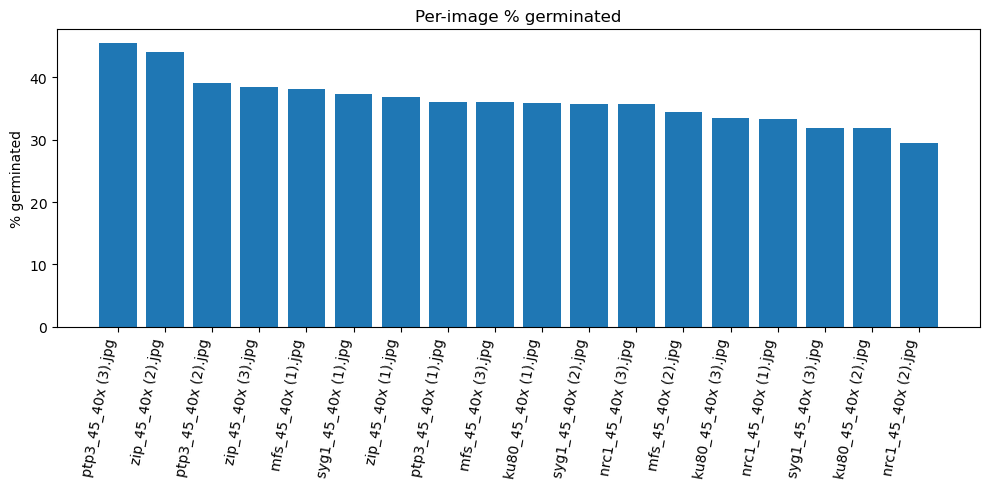

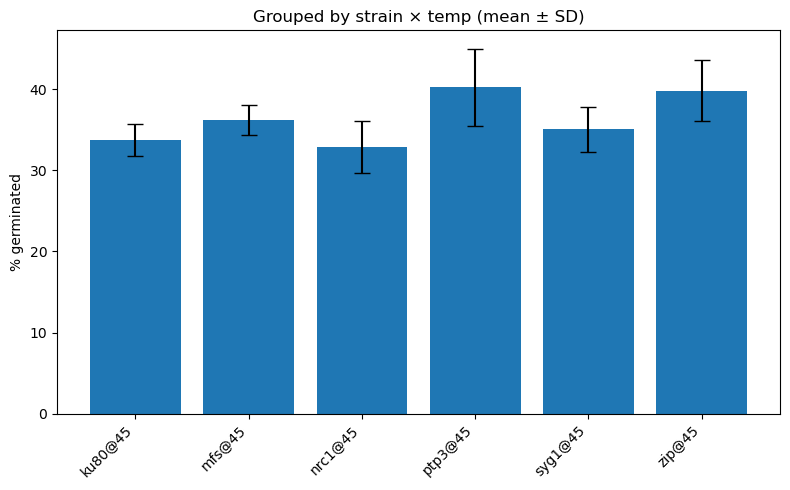

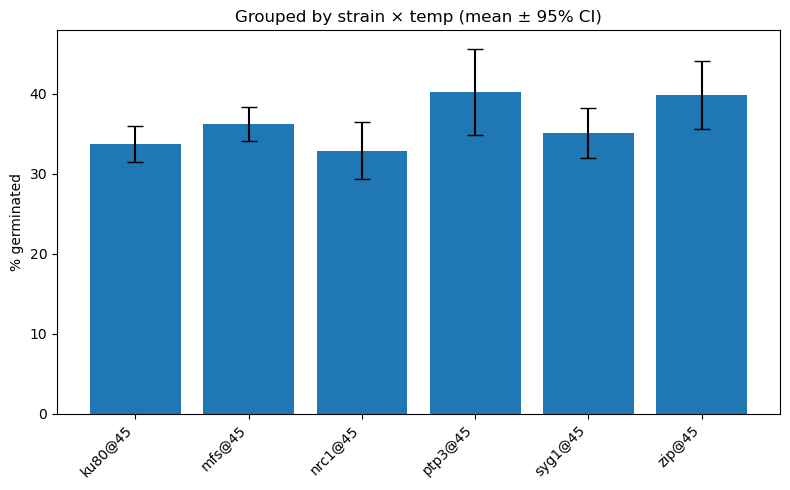

,strain,temp,mean,std,count,sem,ci95
0,ku80,45,33.749484,1.981611,3,1.144084,2.242404
1,mfs,45,36.199280,1.899412,3,1.096626,2.149387
2,nrc1,45,32.861782,3.165281,3,1.827476,3.581853
3,ptp3,45,40.228536,4.772663,3,2.755498,5.400776
4,syg1,45,35.056929,2.784588,3,1.607683,3.151058
5,zip,45,39.820273,3.747705,3,2.163739,4.240928


In [5]:
# === Batch Fungal Germination Counter (Jupyter version) ======================
# Adds: mean±SD/SEM/95% CI per strain×temp + error-bar plots + replicate parsing

import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/45C"
input_glob = os.path.join(image_folder, "*.jpg")
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"  # include all 6 strains
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# Segmentation & classification thresholds (tune if needed)
MIN_AREA = 25
MAX_AREA = 10000
ASPECT_THRESHOLD = 2.0           # stricter
SKELETON_DIAM_RATIO = 1.8        # stricter
SAUVOLA_WINDOW = 61
SAUVOLA_K = 0.2
GAUSSIAN_SIGMA = 1.0
OPENING_RADIUS = 1
HOLE_AREA = 64
WATERSHED_SPLIT = True
PEAK_FOOTPRINT = 15
# -----------------------------------------------------------------------------

# ----------------------- CORE FUNCTIONS --------------------------------------
def parse_meta(filename, meta_regex=None):
    """Parse strain, temp, and replicate from filename."""
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}

    # Regex with named groups (recommended)
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")

    # Fallback heuristics (if regex not provided or didn’t match)
    s = base.lower()
    if info["strain"] is None:
        for key in ["ku80", "mfs", "zip", "wt", "ptp3", "syg1", "nrc1"]:
            if key in s:
                info["strain"] = key
                break
    if info["temp"] is None:
        mt = re.search(r"(?:^|_|-)(\d{2})(?:c|deg|$|_|-)", s)
        if mt:
            info["temp"] = mt.group(1)

    # Replicate like " (3).jpg"
    mr = re.search(r"\((\d+)\)", base)
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    """Return (DataFrame, overlay_array) for a single image."""
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)

    # Enhance & invert (helps for phase-contrast)
    g = exposure.equalize_adapthist(gray, clip_limit=0.01)
    inv = 1.0 - g
    blur = filters.gaussian(inv, sigma=GAUSSIAN_SIGMA)

    # Adaptive threshold + cleanup
    th = filters.threshold_sauvola(blur, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bw = blur > th
    bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
    bw = morphology.remove_small_objects(bw, MIN_AREA)
    bw = morphology.binary_opening(bw, morphology.disk(OPENING_RADIUS))

    # Optional: split touching objects
    if WATERSHED_SPLIT:
        dist = ndi.distance_transform_edt(bw)
        coords = feature.peak_local_max(
            dist, footprint=np.ones((PEAK_FOOTPRINT, PEAK_FOOTPRINT)), labels=bw, exclude_border=False
        )
        seeds = np.zeros_like(dist, dtype=bool)
        if coords.size:
            seeds[tuple(coords.T)] = True
        markers = measure.label(seeds)
        labels = segmentation.watershed(-dist, markers, mask=bw)
    else:
        labels = measure.label(bw)

    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        maj = max(p.major_axis_length, 1.0)
        minr = max(p.minor_axis_length, 1.0)
        aspect = maj / minr
        equiv  = p.equivalent_diameter

        skel = morphology.skeletonize(labels == p.label)
        sklen = int(np.count_nonzero(skel))

        # Classification rule (OR)
        is_germ = (aspect >= ASPECT_THRESHOLD) or (sklen >= SKELETON_DIAM_RATIO * equiv)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "major_axis_px": float(maj),
            "minor_axis_px": float(minr),
            "aspect_ratio": float(aspect),
            "equiv_diameter_px": float(equiv),
            "skeleton_len_px": int(sklen),
            "is_germinated": int(is_germ),
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    return pd.DataFrame(rows), overlay
# -----------------------------------------------------------------------------

# ----------------------- RUN BATCH -------------------------------------------
paths = [p for p in glob.glob(input_glob)
         if os.path.splitext(p)[1].lower() in {".png", ".jpg", ".jpeg", ".tif", ".tiff"}]
assert len(paths) > 0, f"No images found at: {input_glob}"

all_rows = []
meta_rows = []
for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)

    if meta["strain"] is not None: df["strain"] = meta["strain"]
    if meta["temp"]   is not None: df["temp"]   = meta["temp"]
    if meta["replicate"] is not None: df["replicate"] = meta["replicate"]

    all_rows.append(df)

    # Save overlays
    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    print(f"{os.path.basename(p)} -> N={len(df)}  germinated={int(df.is_germinated.sum())}  overlay={os.path.basename(out_png)}")

# Per-object table
big = pd.concat(all_rows, ignore_index=True)
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# ----------------------- SUMMARIES -------------------------------------------
# Per-image summary (% germinated)
per_file = big.groupby("file").agg(
    total=("is_germinated","count"),
    germinated=("is_germinated","sum")
).reset_index()
per_file["percent_germinated"] = 100 * per_file["germinated"] / per_file["total"].clip(lower=1)
per_file.to_csv(f"{output_prefix}_perfile.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perfile.csv")

# Compute per-image % then aggregate by strain×temp to get mean/SD/SEM/CI
per_file_with_meta = per_file.merge(
    big[["file","strain","temp"]].drop_duplicates(), on="file", how="left"
)

summary = (
    per_file_with_meta
    .groupby(["strain","temp"])["percent_germinated"]
    .agg(["mean","std","count"])
    .reset_index()
)
summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
summary["ci95"] = 1.96 * summary["sem"]
summary = summary.sort_values(["strain","temp"])
summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)
print("Saved grouped stats (mean, SD, SEM, 95% CI):", f"{output_prefix}_by_strain_temp_stats.csv")

# ----------------------- PLOTS (with error bars) -----------------------------
# Per-image (no error bars; each is a single estimate)
plt.figure(figsize=(10, 5))
order = per_file.sort_values("percent_germinated", ascending=False)
plt.bar(order["file"], order["percent_germinated"])
plt.xticks(rotation=80, ha="right")
plt.ylabel("% germinated")
plt.title("Per-image % germinated")
plt.tight_layout()
plt.show()

# Grouped mean ± SD
plt.figure(figsize=(8, 5))
labels = [f"{r.strain}@{r.temp}" for r in summary.itertuples()]
plt.bar(labels, summary["mean"], yerr=summary["std"], capsize=6)
plt.xticks(rotation=45, ha="right")
plt.ylabel("% germinated")
plt.title("Grouped by strain × temp (mean ± SD)")
plt.tight_layout()
plt.show()

# Grouped mean ± 95% CI (often nicer to compare means)
plt.figure(figsize=(8, 5))
plt.bar(labels, summary["mean"], yerr=summary["ci95"], capsize=6)
plt.xticks(rotation=45, ha="right")
plt.ylabel("% germinated")
plt.title("Grouped by strain × temp (mean ± 95% CI)")
plt.tight_layout()
plt.show()

# Peek
summary.head(10)


ku80_37 (1).jpg -> N=233  germinated=71  overlay=ku80_37 (1)_overlay.png
ku80_37 (2).jpg -> N=229  germinated=65  overlay=ku80_37 (2)_overlay.png
ku80_37 (3).jpg -> N=104  germinated=47  overlay=ku80_37 (3)_overlay.png
ku80_37 (4).jpg -> N=88  germinated=39  overlay=ku80_37 (4)_overlay.png
mfs_37 (1).jpg -> N=141  germinated=43  overlay=mfs_37 (1)_overlay.png
mfs_37 (2).jpg -> N=163  germinated=54  overlay=mfs_37 (2)_overlay.png
mfs_37 (3).jpg -> N=184  germinated=59  overlay=mfs_37 (3)_overlay.png
mfs_37 (4).jpg -> N=75  germinated=29  overlay=mfs_37 (4)_overlay.png
nrc1_37_40X (1).jpg -> N=140  germinated=40  overlay=nrc1_37_40X (1)_overlay.png
nrc1_37_40X (2).jpg -> N=84  germinated=30  overlay=nrc1_37_40X (2)_overlay.png
nrc1_37_40X (3).jpg -> N=79  germinated=37  overlay=nrc1_37_40X (3)_overlay.png
nrc1_37_40X.jpg -> N=66  germinated=31  overlay=nrc1_37_40X_overlay.png
nrc1_37_40x_2 (1).jpg -> N=128  germinated=42  overlay=nrc1_37_40x_2 (1)_overlay.png
nrc1_37_40x_2 (2).jpg -> N=8

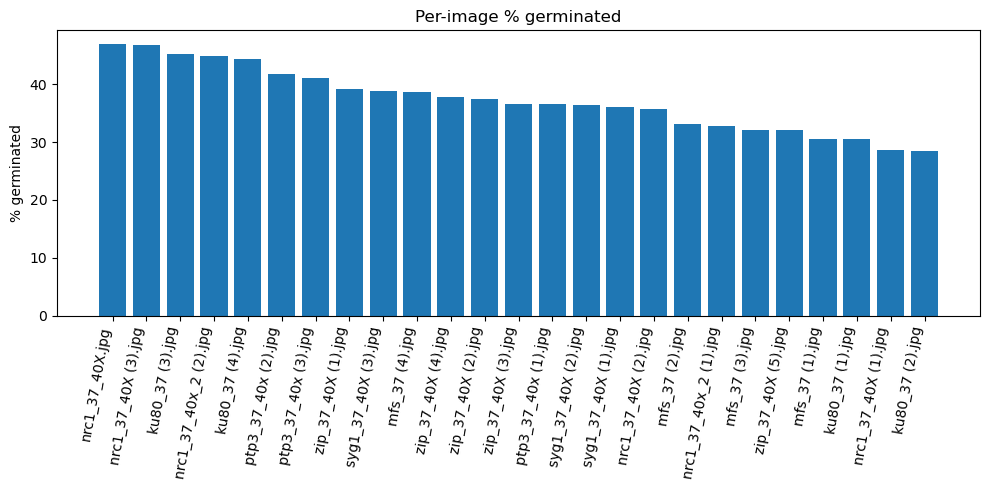

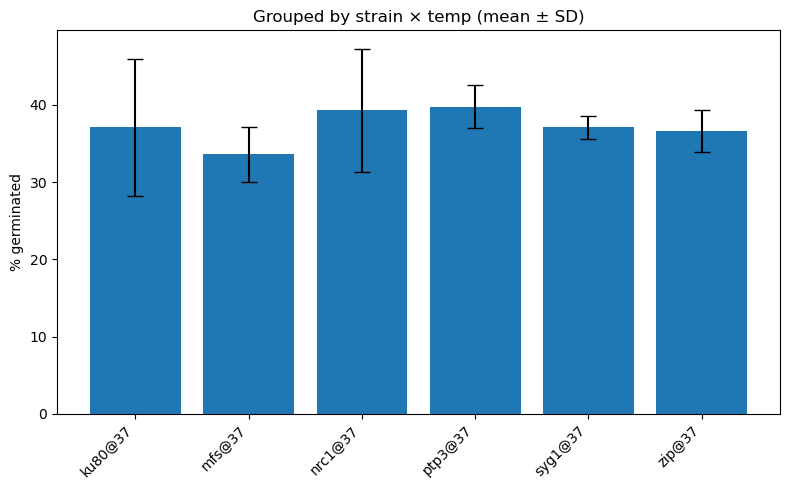

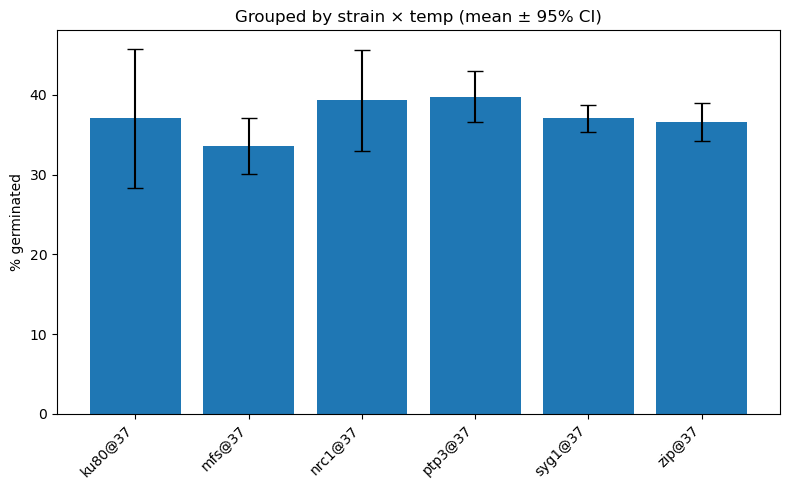

,strain,temp,mean,std,count,sem,ci95
0,ku80,37,37.091718,8.897193,4,4.448596,8.719249
1,mfs,37,33.589293,3.553412,4,1.776706,3.482344
2,nrc1,37,39.307862,7.968773,6,3.253238,6.376347
3,ptp3,37,39.759359,2.824846,3,1.630926,3.196614
4,syg1,37,37.099078,1.495186,3,0.863246,1.691962
5,zip,37,36.576029,2.691101,5,1.203497,2.358854


In [6]:
# === Batch Fungal Germination Counter (Jupyter version) ======================
# Adds: mean±SD/SEM/95% CI per strain×temp + error-bar plots + replicate parsing

import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, measure, exposure, segmentation, feature, util
from scipy import ndimage as ndi

# ----------------------- USER SETTINGS ---------------------------------------
image_folder = "/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/37C"
input_glob = os.path.join(image_folder, "*.jpg")
meta_regex = r"(?P<strain>ku80|mfs|zip|syg1|nrc1|ptp3)_(?P<temp>\d+)"  # include all 6 strains
save_overlays_next_to_images = True
output_prefix = os.path.join(image_folder, "germination_measurements_all")

# Segmentation & classification thresholds (tune if needed)
MIN_AREA = 25
MAX_AREA = 10000
ASPECT_THRESHOLD = 2.0           # stricter
SKELETON_DIAM_RATIO = 1.8        # stricter
SAUVOLA_WINDOW = 61
SAUVOLA_K = 0.2
GAUSSIAN_SIGMA = 1.0
OPENING_RADIUS = 1
HOLE_AREA = 64
WATERSHED_SPLIT = True
PEAK_FOOTPRINT = 15
# -----------------------------------------------------------------------------

# ----------------------- CORE FUNCTIONS --------------------------------------
def parse_meta(filename, meta_regex=None):
    """Parse strain, temp, and replicate from filename."""
    base = os.path.basename(filename)
    info = {"strain": None, "temp": None, "replicate": None}

    # Regex with named groups (recommended)
    if meta_regex:
        m = re.search(meta_regex, base, flags=re.IGNORECASE)
        if m:
            info["strain"] = m.groupdict().get("strain")
            info["temp"]   = m.groupdict().get("temp")

    # Fallback heuristics (if regex not provided or didn’t match)
    s = base.lower()
    if info["strain"] is None:
        for key in ["ku80", "mfs", "zip", "wt", "ptp3", "syg1", "nrc1"]:
            if key in s:
                info["strain"] = key
                break
    if info["temp"] is None:
        mt = re.search(r"(?:^|_|-)(\d{2})(?:c|deg|$|_|-)", s)
        if mt:
            info["temp"] = mt.group(1)

    # Replicate like " (3).jpg"
    mr = re.search(r"\((\d+)\)", base)
    if mr:
        info["replicate"] = int(mr.group(1))
    return info

def analyze_image(path):
    """Return (DataFrame, overlay_array) for a single image."""
    img = io.imread(path)
    gray = color.rgb2gray(img) if img.ndim == 3 else img.astype(float)
    gray = util.img_as_float(gray)

    # Enhance & invert (helps for phase-contrast)
    g = exposure.equalize_adapthist(gray, clip_limit=0.01)
    inv = 1.0 - g
    blur = filters.gaussian(inv, sigma=GAUSSIAN_SIGMA)

    # Adaptive threshold + cleanup
    th = filters.threshold_sauvola(blur, window_size=SAUVOLA_WINDOW, k=SAUVOLA_K)
    bw = blur > th
    bw = morphology.remove_small_holes(bw, area_threshold=HOLE_AREA)
    bw = morphology.remove_small_objects(bw, MIN_AREA)
    bw = morphology.binary_opening(bw, morphology.disk(OPENING_RADIUS))

    # Optional: split touching objects
    if WATERSHED_SPLIT:
        dist = ndi.distance_transform_edt(bw)
        coords = feature.peak_local_max(
            dist, footprint=np.ones((PEAK_FOOTPRINT, PEAK_FOOTPRINT)), labels=bw, exclude_border=False
        )
        seeds = np.zeros_like(dist, dtype=bool)
        if coords.size:
            seeds[tuple(coords.T)] = True
        markers = measure.label(seeds)
        labels = segmentation.watershed(-dist, markers, mask=bw)
    else:
        labels = measure.label(bw)

    props = measure.regionprops(labels)
    rows = []
    overlay = color.gray2rgb((g * 255).astype(np.uint8))

    for p in props:
        if p.area < MIN_AREA or p.area > MAX_AREA:
            continue

        maj = max(p.major_axis_length, 1.0)
        minr = max(p.minor_axis_length, 1.0)
        aspect = maj / minr
        equiv  = p.equivalent_diameter

        skel = morphology.skeletonize(labels == p.label)
        sklen = int(np.count_nonzero(skel))

        # Classification rule (OR)
        is_germ = (aspect >= ASPECT_THRESHOLD) or (sklen >= SKELETON_DIAM_RATIO * equiv)

        rows.append({
            "file": os.path.basename(path),
            "label": int(p.label),
            "area_px": int(p.area),
            "major_axis_px": float(maj),
            "minor_axis_px": float(minr),
            "aspect_ratio": float(aspect),
            "equiv_diameter_px": float(equiv),
            "skeleton_len_px": int(sklen),
            "is_germinated": int(is_germ),
        })

        rr, cc = p.coords[:, 0], p.coords[:, 1]
        overlay[rr, cc] = [0, 255, 0] if is_germ else [255, 0, 0]

    return pd.DataFrame(rows), overlay
# -----------------------------------------------------------------------------

# ----------------------- RUN BATCH -------------------------------------------
paths = [p for p in glob.glob(input_glob)
         if os.path.splitext(p)[1].lower() in {".png", ".jpg", ".jpeg", ".tif", ".tiff"}]
assert len(paths) > 0, f"No images found at: {input_glob}"

all_rows = []
meta_rows = []
for p in sorted(paths):
    df, overlay = analyze_image(p)
    meta = parse_meta(p, meta_regex)

    if meta["strain"] is not None: df["strain"] = meta["strain"]
    if meta["temp"]   is not None: df["temp"]   = meta["temp"]
    if meta["replicate"] is not None: df["replicate"] = meta["replicate"]

    all_rows.append(df)

    # Save overlays
    out_png = (os.path.splitext(p)[0] + "_overlay.png") if save_overlays_next_to_images \
              else os.path.join(image_folder, os.path.basename(os.path.splitext(p)[0]) + "_overlay.png")
    io.imsave(out_png, overlay)

    print(f"{os.path.basename(p)} -> N={len(df)}  germinated={int(df.is_germinated.sum())}  overlay={os.path.basename(out_png)}")

# Per-object table
big = pd.concat(all_rows, ignore_index=True)
big.to_csv(f"{output_prefix}.csv", index=False)
print("Saved per-object measurements:", f"{output_prefix}.csv")

# ----------------------- SUMMARIES -------------------------------------------
# Per-image summary (% germinated)
per_file = big.groupby("file").agg(
    total=("is_germinated","count"),
    germinated=("is_germinated","sum")
).reset_index()
per_file["percent_germinated"] = 100 * per_file["germinated"] / per_file["total"].clip(lower=1)
per_file.to_csv(f"{output_prefix}_perfile.csv", index=False)
print("Saved per-image summary:", f"{output_prefix}_perfile.csv")

# Compute per-image % then aggregate by strain×temp to get mean/SD/SEM/CI
per_file_with_meta = per_file.merge(
    big[["file","strain","temp"]].drop_duplicates(), on="file", how="left"
)

summary = (
    per_file_with_meta
    .groupby(["strain","temp"])["percent_germinated"]
    .agg(["mean","std","count"])
    .reset_index()
)
summary["sem"] = summary["std"] / np.sqrt(summary["count"].clip(lower=1))
summary["ci95"] = 1.96 * summary["sem"]
summary = summary.sort_values(["strain","temp"])
summary.to_csv(f"{output_prefix}_by_strain_temp_stats.csv", index=False)
print("Saved grouped stats (mean, SD, SEM, 95% CI):", f"{output_prefix}_by_strain_temp_stats.csv")

# ----------------------- PLOTS (with error bars) -----------------------------
# Per-image (no error bars; each is a single estimate)
plt.figure(figsize=(10, 5))
order = per_file.sort_values("percent_germinated", ascending=False)
plt.bar(order["file"], order["percent_germinated"])
plt.xticks(rotation=80, ha="right")
plt.ylabel("% germinated")
plt.title("Per-image % germinated")
plt.tight_layout()
plt.show()

# Grouped mean ± SD
plt.figure(figsize=(8, 5))
labels = [f"{r.strain}@{r.temp}" for r in summary.itertuples()]
plt.bar(labels, summary["mean"], yerr=summary["std"], capsize=6)
plt.xticks(rotation=45, ha="right")
plt.ylabel("% germinated")
plt.title("Grouped by strain × temp (mean ± SD)")
plt.tight_layout()
plt.show()

# Grouped mean ± 95% CI (often nicer to compare means)
plt.figure(figsize=(8, 5))
plt.bar(labels, summary["mean"], yerr=summary["ci95"], capsize=6)
plt.xticks(rotation=45, ha="right")
plt.ylabel("% germinated")
plt.title("Grouped by strain × temp (mean ± 95% CI)")
plt.tight_layout()
plt.show()

# Peek
summary.head(10)
